In [ ]:
"""
EEG Conformer
Convolutional Transformer for EEG decoding
Couple CNN and Transformer in a concise manner with amazing results
"""
# remember to change paths

import os
gpus = [0]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
import numpy as np
import math
import random
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True

# Convolution module
# use conv to capture local features, instead of postion embedding.
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # transpose, conv could enhance fiting ability slightly
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))


class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()

        # global average pooling
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(3080, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return out


class Conformer(nn.Module):
    def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
        super().__init__()
        self.net = nn.Sequential(
            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )

    def forward(self, x, targets):
        out_values = {}
        logits = self.net(x)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss, out_values

In [ ]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc


import torch
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc


class TrainerTester:

    @staticmethod
    def train_loop(model_loop, optimizer_loop, X_train, y_train, X_test, y_test, lr, ud, batch_size=32, iterations=1000):
        lossi = []
        accuracyi = []
        lossv = []
        accuracyv = []
        for k in range(iterations):
            batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,))
            batch_test_indexes = torch.randint(0, X_test.shape[0], (batch_size,))

            X_batch, y_batch = X_train[batch_indexes], y_train[batch_indexes]  # train batch X,Y

            #data augmentation
            # X_batch, _ = transforms['freq'].operation(X_batch, None, 10., sfreq)
            # X_batch, _ = transforms['gauss'].operation(X_batch, None, std=1e-5)

            X_test_batch, y_test_batch = X_test[batch_test_indexes], y_test[batch_test_indexes]  # test batch X,Y

            pred, loss, out_values = model_loop(X_batch,  y_batch)

            # Backpropagation
            optimizer_loop.zero_grad()
            loss.backward()
            optimizer_loop.step()

            with torch.no_grad():
                #tracking training metrics
                lossi.append(loss.item())
                accuracyi.append((pred.argmax(1) == y_batch).type(torch.float32).sum().item() / y_batch.shape[0])

                #tracking test metrics
                test_loss, test_accuracy = TrainerTester.test_loss(model_loop, X_test_batch, y_test_batch)
                lossv.append(test_loss)
                accuracyv.append(test_accuracy)

                if (k+1) % 100 == 0:
                    print(f"loss: {loss} iteration: {k+1}/{iterations}")
                    plt.title('loss')
                    plt.plot(torch.tensor(lossv).view(-1, 10).mean(dim=1).tolist(), label="test loss")
                    plt.plot(torch.tensor(lossi).view(-1, 10).mean(dim=1).tolist(), label="train loss")
                    plt.show()

                    plt.title('accuracy')
                    plt.plot(torch.tensor(accuracyv).view(-1, 10).mean(dim=1).tolist(), label="test accuracy")
                    plt.plot(torch.tensor(accuracyi).view(-1, 10).mean(dim=1).tolist(), label="train accuracy")
                    plt.show()

                # ud.append([((lr * p.grad).std() / p.data.std()).item() for p in model_loop.parameters()])

        return lossi

    @staticmethod
    def test_loss(model_loop, X_test,  y_test):
        model_loop.eval()
        with torch.no_grad():
            pred, loss, out_values = model_loop(X_test, y_test)
            accuracy = (pred.argmax(1) == y_test).type(torch.float32).sum().item() / y_test.shape[0]
        model_loop.train()
        return loss, accuracy

    @staticmethod
    def test_loop(model_loop, X_test,  y_test):
        model_loop.eval()
        with torch.no_grad():
            pred, loss, out_values = model_loop(X_test, y_test)
            accuracy = (pred.argmax(1) == y_test).type(torch.float32).sum().item() / y_test.shape[0]
            kappa = cohen_kappa_score(pred.argmax(1), y_test)

        print(f"Test loss: {loss:>8f} \n Accuracy: {accuracy:>8f} \n kappa: {kappa} \n")
        model_loop.train()
        return out_values

    @staticmethod
    def test_and_show(model_loop, X_test,  y_test):
        model_loop.eval()
        with torch.no_grad():
            pred, loss, out_values = model_loop(X_test,  y_test)
            accuracy = pred.argmax(1) == y_test
            model_loop.train()
            return accuracy



In [ ]:
from sklearn.model_selection import StratifiedKFold

seed = 1330
splits = 5
# lr=0.0002
lr=3e-3
b1 = 0.5
b2 = 0.999
device = 'cuda' if torch.cuda.is_available() else 'cpu'

conformer = Conformer()
skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
# optimizer = torch.optim.Adam(conformer.parameters(), lr=lr, betas=(b1, b2))
optimizer = torch.optim.AdamW(conformer.parameters(), lr=lr, weight_decay=0.3)

In [ ]:
from modules.BciDataHandler import BciDataHandler

data_handler = BciDataHandler()
data_handler.instantiate_dataset()

In [ ]:
import mne

# ------------------------------ bci competition dataset ------------------------------
all_subject_epochs = mne.concatenate_epochs(list(data_handler.subjects_epochs.values()))
all_labels = all_subject_epochs.events[:, -1] - 1

epochs = data_handler.subjects_epochs[1]
labels = np.array(data_handler.subjects_labels[1]) - 1

# epochs = all_subject_epochs
# labels = all_labels
# labels

In [ ]:
data = epochs.get_data()
X = torch.tensor(data).to(dtype=torch.float32, device=device)
y = torch.tensor(labels).to(dtype=torch.long, device=device)

loss: 1.3937311172485352 iteration: 100/2000


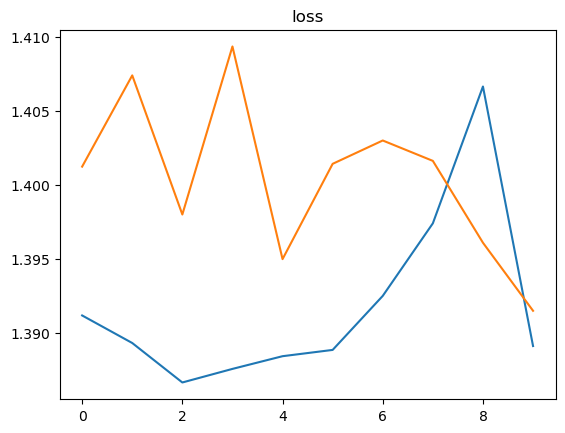

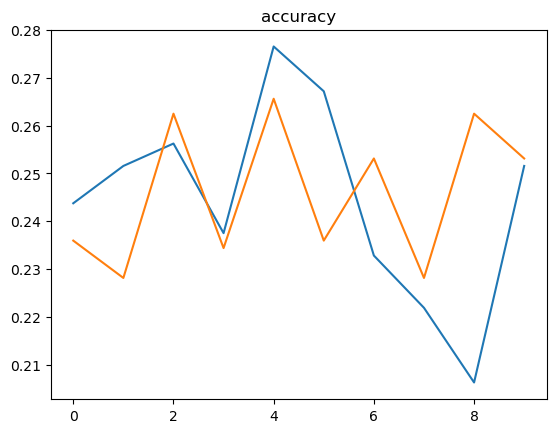

KeyboardInterrupt: 

In [16]:
X_conformer = X.unsqueeze(1)

ud = []

#main-trianing-loop
for train_index, test_index in skf.split(X_conformer, y):
    X_train, X_test = X_conformer[train_index], X_conformer[test_index],
    y_train, y_test = y[train_index], y[test_index]

    TrainerTester.train_loop(conformer, optimizer, X_train, y_train, X_test, y_test, lr, ud, batch_size=64, iterations=2000)

    out_values = TrainerTester.test_loop(conformer, X_test, y_test)
    break